In [1]:
import os
os.chdir("/sfs/gpfs/tardis/home/dpv8cf/toxic-comment-analysis")  # adjust if needed
os.getcwd()


'/sfs/gpfs/tardis/home/dpv8cf/toxic-comment-analysis'

In [3]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import sys
sys.path.append("scripts")
import data_cleaning
from torch.utils.data import TensorDataset, DataLoader


In [4]:
data = pd.read_csv("data/train.csv")

In [5]:
data = data_cleaning.clean_data(data)

In [6]:
data.shape, data.columns

((1593229, 15),
 Index(['comment_text', 'funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity',
        'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack',
        'insult', 'threat', 'toxicity_annotator_count', 'rating_rejected'],
       dtype='object'))

I will only use "comment_text" as an input and rating_rejected as a label. 

In [7]:
data = data[["comment_text", "rating_rejected"]].copy()
data["comment_text"] = data["comment_text"].fillna("").astype(str)
data["rating_rejected"] = data["rating_rejected"].astype(int)

data.head(), data["rating_rejected"].value_counts()

(                                        comment_text  rating_rejected
 0  That was the reason Walker fire everyone now w...                0
 1  So my original statement still stands . A chur...                0
 2  All you ever do is come to these forums berati...                1
 3  Tonight will be an excellent opportunity for C...                0
 4  I read about this on Stars and Stripes oversea...                0,
 0    1488469
 1     104760
 Name: rating_rejected, dtype: int64)

In [8]:
from sklearn.model_selection import train_test_split
X_text = data["comment_text"]
y = data["rating_rejected"].values
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train = tfidf.fit_transform(X_train_text)
X_val   = tfidf.transform(X_val_text)

X_train_dense = X_train.toarray().astype(np.float32)
X_val_dense   = X_val.toarray().astype(np.float32)

X_train_dense.shape, X_val_dense.shape

((1274583, 2000), (318646, 2000))

TfidfVectorizer converts raw text into numerical features that a machine learning model can understand. The parameter max_features limits the vocabulary to the top n most frequent and informative words.
While a larger max_features value might capture more detail from the dataset, it also drastically increases memory usage. To balance information and RAM constraints, we use 2000 features, which provides meaningful signal without overwhelming system memory.

The parameter ngram_range=(1, 2) tells the vectorizer to include both unigrams (single words) and bigrams (two-word phrases), such as “good” and “not good.” Including bigrams helps capture richer contextual meaning.

stop_words="english" removes extremely common words like “the,” “and,” or “is,” which usually do not contribute useful information for classification.

The fit_transform function does two things for the training set:

fit — reads all training text, learns the vocabulary, and calculates TF-IDF statistics

transform — converts each training comment into a sparse TF-IDF vector

For the validation set, we only use transform (without fit) to avoid data leakage, ensuring the model does not learn vocabulary from data it should not have seen during training.

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

X_train_tensor = torch.from_numpy(X_train_dense)
y_train_tensor = torch.from_numpy(y_train.astype(np.int64))

X_val_tensor = torch.from_numpy(X_val_dense)
y_val_tensor = torch.from_numpy(y_val.astype(np.int64))

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)


In [12]:
import torch.nn as nn

input_dim = X_train_dense.shape[1]
hidden_dim = 256

class ToxicMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, 1)  # 1 logit
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = ToxicMLP(input_dim, hidden_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            all_logits.append(logits.cpu())
            all_labels.append(y_batch)
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits).numpy()
    preds = (probs >= 0.5).astype(int)
    labels = all_labels.numpy()

    acc = accuracy_score(labels, preds)
    return acc, probs, preds, labels

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_acc, _, _, _ = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}/{num_epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")


Epoch 1/5 | Train loss: 0.2288 | Val acc: 0.9347
Epoch 2/5 | Train loss: 0.2218 | Val acc: 0.9349
Epoch 3/5 | Train loss: 0.2190 | Val acc: 0.9350
Epoch 4/5 | Train loss: 0.2165 | Val acc: 0.9351
Epoch 5/5 | Train loss: 0.2138 | Val acc: 0.9350


In [14]:
val_acc, probs, preds, labels = evaluate(model, val_loader, device)
print("Validation accuracy:", val_acc)
print("\nClassification report:\n")
print(classification_report(labels, preds, digits=4))
print("\nConfusion matrix:\n")
print(confusion_matrix(labels, preds))


Validation accuracy: 0.935021936569108

Classification report:

              precision    recall  f1-score   support

           0     0.9363    0.9984    0.9663    297694
           1     0.6020    0.0348    0.0658     20952

    accuracy                         0.9350    318646
   macro avg     0.7691    0.5166    0.5161    318646
weighted avg     0.9143    0.9350    0.9071    318646


Confusion matrix:

[[297212    482]
 [ 20223    729]]


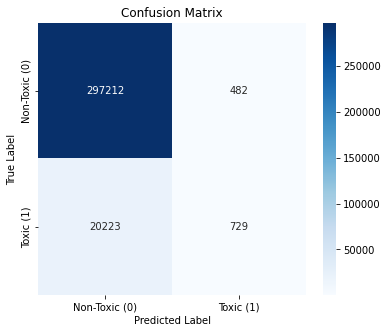

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Toxic (0)", "Toxic (1)"],
            yticklabels=["Non-Toxic (0)", "Toxic (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
